In [1]:
import sys, os
import pandas as pd
import netCDF4 as nc
import numpy as np
sys.path.append('../src/')
from Biologging_Toolkit.applications.Mixed_Layer_Depth import MixedLayerDepth
from Biologging_Toolkit.processing.Dives import Dives
from Biologging_Toolkit.utils.format_utils import get_start_time_sens

/home6/grosmaan/Documents/SES_tags/notebooks/../src/Biologging_Toolkit


In [2]:
depid = 'ml18_294b'
path = os.path.join('D:/individus_brut/individus/', depid)
ref_path = os.path.join(path, 'data', 'auxiliary', 'instrument')
sens_path = os.path.join(ref_path, depid+'sens5.nc')

### Make sure csv structure for dive data exists

In [ ]:
dive = Dives(depid, path = ref_path, sens_path = sens_path)

In [ ]:
dive()

### Add temperature data to reference structure

In [ ]:
ds = nc.Dataset(sens_path)
temperature = ds['T'][:].data
temp_time = get_start_time_sens(ds.dephist_device_datetime_start) + np.arange(0, len(temperature))/5

In [ ]:
dive.create_variable('temperature',
                     var_data =  temperature,
                     var_time = temp_time)

In [ ]:
dive.ds

In [ ]:
dive.ds.close()

### Compute mixed layer depth

In [ ]:
inst = MixedLayerDepth(depid, 
            path = ref_path
           )

In [ ]:
inst()

### Wind correlation with MLD

In [6]:
depids = ['ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_293a','ml20_296b','ml20_313a','ml21_295a','ml21_305b','ml17_280a']
path = '/run/media/grosmaan/LaCie/individus_brut/individus/'
paths = [os.path.join(path, depid) for depid in depids]

In [7]:
from Biologging_Toolkit.applications.Wind import Wind
from Biologging_Toolkit.utils.plot_utils import subplots_centered
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
plt.rcParams.update({
    "text.usetex": True,                # Enable LaTeX text rendering
    "font.family": "serif",             # Use a serif font
    "font.serif": ["Computer Modern"],  # Set font to Computer Modern (LaTeX default)
})
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [8]:
depids_with_mld = []
for depid in depids :
    df = pd.read_csv(os.path.join(path, depid, f'{depid}_dive.csv'))
    try :
        if np.all(np.isnan(df.meop_mld.to_numpy())):
            continue
        depids_with_mld.append(depid)
    except AttributeError:
        continue
print(depids_with_mld)

['ml18_296a', 'ml18_294b', 'ml19_292b', 'ml19_293a', 'ml19_294a', 'ml20_293a', 'ml20_296b', 'ml20_313a', 'ml21_295a', 'ml21_305b', 'ml17_280a']


In [ ]:
def get_previous_wind_single(df, data, groupby = 'FOD') :
    wind_interp = interp1d(df.end_time, df[data], bounds_error = False)
    for i in range(48):
        df[f'wind_{i}h'] = wind_interp(df.end_time - i*3600)
    if groupby :
        data = ['meop_mld', groupby]
    else :
        data = ['meop_mld']
    for i in range(48):
        data.append(f'wind_{i}h')
    return df[data]

In [ ]:
def get_previous_wind(df, data) :
    wind_interp = interp1d(df.end_time, df.wind_speed, bounds_error = False)
    pensieri_interp = interp1d(df.end_time, df.pensieri, bounds_error = False)
    lstm_interp = interp1d(df.end_time, df.lstm, bounds_error = False)
    hild_interp = interp1d(df.end_time, df.hildebrand, bounds_error = False)
    for i in range(48):
        df[f'wind_{i}h'] = wind_interp(df.end_time - i*3600)
        df[f'pensieri_{i}h'] = pensieri_interp(df.end_time - i*3600)
        df[f'lstm_{i}h'] = lstm_interp(df.end_time - i*3600)
        df[f'hildebrand_{i}h'] = hild_interp(df.end_time - i*3600)
    return df

In [ ]:
def get_correlation(depids, depid, path, data = 'downwards_mean_5000', FOD = 'FOD') :
    df = pd.read_csv(os.path.join(path, depid, f'{depid}_dive.csv'))
    inst = Wind(depids, path = paths, test_depid = depid, data = data)
    inst.depid_fit()
    est = inst.df[inst.df.depid == depid].depid_estimation.to_numpy()
    df['pensieri'] = est
    inst = Wind(depids, path = paths, test_depid = depid, data = data, method = 'Hildebrand')
    inst.depid_fit()
    est = inst.df[inst.df.depid == depid].depid_estimation.to_numpy()
    df['hildebrand'] = est
    df = get_previous_wind(df, data = data)
    if FOD :
        data_pens = ['meop_mld', FOD]; data_era = ['meop_mld', FOD]; data_lstm = ['meop_mld', FOD]; data_hild = ['meop_mld', FOD]
    else :
        data_pens = ['meop_mld']; data_era = ['meop_mld']; data_lstm = ['meop_mld']; data_hild = ['meop_mld']
    for i in range(48):
        data_pens.append(f'pensieri_{i}h')
        data_era.append(f'wind_{i}h')
        data_lstm.append(f'lstm_{i}h')
        data_hild.append(f'hildebrand_{i}h')
    return df[data_era], df[data_pens], df[data_lstm], df[data_hild]

In [ ]:
colors = colormaps.get_cmap('plasma').resampled(5)
FOD = True
fod_labels = [1,2,3,4,5]

df = pd.DataFrame()
for i, depid in enumerate(depids_with_mld) :
    _df = pd.read_csv(os.path.join(path, depid, f'{depid}_dive.csv'))
    _df = get_previous_wind_single(_df, 'lstm', groupby = 'temp_200m')
    for avg in range(2, 25) :
        _roll = _df.iloc[:, 2:50].rolling(avg, min_periods=1, center=True).mean()
        _roll.columns = [f'avg{avg}_{col}' for col in list(_roll.columns)]
        _df = pd.concat((_df, _roll), axis = 1)
    df = pd.concat((df, _df))
    
temp_bins = [0, 3, 6, 12.5, float('inf')]
mld_bins = [0, df['meop_mld'].quantile(0.33), df['meop_mld'].quantile(0.66), np.inf]
temp_bins = [0, df['temp_200m'].quantile(0.25), df['temp_200m'].quantile(0.5), df['temp_200m'].quantile(0.75), np.inf]
labels = [1, 2, 3, 4]
df['bins'] = pd.cut(df['temp_200m'], bins=temp_bins, labels=labels, right=False)

if FOD:
    fig, ax = plt.subplots(2,2,figsize = (12, 12), sharey = True)
    ax = ax.flatten()
    for k in range(1, 5):
        sns.heatmap(
            df[df.bins == k].corr()['meop_mld'][2:-1].to_numpy().reshape(-1, 48), 
            ax=ax[k - 1],
            cbar_kws={'label': 'Pearson correlation coefficient'}
        )
        ax[k-1].set_title(f'Bin {k}')
else :
    fig, ax = plt.subplots(figsize = (15, 10))
    sns.heatmap(
            df.corr()['meop_mld'][2:-1].to_numpy().reshape(-1, 48), 
            ax=ax,
            cbar_kws={'label': 'Pearson correlation coefficient'}
        )
fig.text(0.5, 0.04, 'Hours before MLD obtention', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, 'Wind averaging period in hours', ha='center', va='center', rotation='vertical', fontsize=14)
fig.tight_layout(rect=[0.05, 0.05, 1, 1])

In [ ]:
fig.savefig('C:/Users/grosm/Desktop/thèse/Figures/wind_averaged_correlation_mld_all_SES.pdf')

In [ ]:
fig, ax = subplots_centered(3,4,figsize = (20, 20), sharey = True, nfigs = 11)
#fig1, ax1 = subplots_centered(3,2,figsize = (10, 10), sharey = True, nfigs = 5)
colors = colormaps.get_cmap('plasma').resampled(5)
FOD = False
df_era = pd.DataFrame()
df_lstm = pd.DataFrame()
df_hild = pd.DataFrame()
df_pens = pd.DataFrame()
for i, depid in enumerate(depids_with_mld) :
    fod_counts = np.array([0,0,0,0,0])
    fod_labels = [1,2,3,4,5]
    _df_era, _df_pens, _df_lstm, _df_hild = get_correlation(depids, depid, path, data = 'upwards_mean_5000', FOD = 'temp_200m')
    df_era = pd.concat((df_era, _df_era))
    df_lstm = pd.concat((df_lstm, _df_lstm))
    df_pens = pd.concat((df_pens, _df_pens))
    df_hild = pd.concat((df_hild, _df_hild))

    #ax1[i].bar(fod_labels, fod_counts, align='center')
    #ax1[i].set_title(depid)
    #ax1[i].grid()
    if FOD :
        labels, counts = np.unique(_df_era.FOD, return_counts=True)
        counts = counts[~np.isnan(labels)]
        labels = labels[~np.isnan(labels)]
        fod_counts[labels.astype(int)-1] = counts
        for k in range(1,6) :
            ax[i].plot(_df_era[_df_era.FOD == k].corr()['meop_mld'][2:].to_numpy(), color = colors(k-1), marker = 's')
        #ax[i].plot(np.nanmean(np.column_stack([df_pens[df_pens.FOD == j].corr()['meop_mld'][2:] for j in range(1,2)]), axis = 1), color = colors(0), marker = '^')
        #ax[i].plot(np.nanmean(np.column_stack([df_hild[df_hild.FOD == j].corr()['meop_mld'][2:] for j in range(1,2)]), axis = 1), color = colors(0), marker = 'P')
        #ax[i].plot(np.nanmean(np.column_stack([df_lstm[df_lstm.FOD == j].corr()['meop_mld'][2:] for j in range(1,2)]), axis = 1), color = colors(2), marker = 'o')
    else :
        ax[i].plot(_df_era.corr()['meop_mld'].to_numpy()[2:], color = colors(3))
        ax[i].plot(_df_pens.corr()['meop_mld'].to_numpy()[2:], color = colors(0))
        ax[i].plot(_df_hild.corr()['meop_mld'].to_numpy()[2:], color = colors(1))
        ax[i].plot(_df_lstm.corr()['meop_mld'].to_numpy()[2:], color = colors(2))
    ax[i].grid()
    ax[i].set_title(depid)
legend_handles = [
    plt.Line2D([0], [0], color=colors(0), lw=2, label="Quadratic"),
    plt.Line2D([0], [0], color=colors(1), lw=2, label="Logarithmic"),
    plt.Line2D([0], [0], color=colors(2), lw=2, label="LSTM"),
    plt.Line2D([0], [0], color=colors(3), lw=2, label="ERA"),
    ]
ax[0].legend(handles = legend_handles)
ax[0].set_xticklabels([])
ax[1].set_xticklabels([])
ax[2].set_xticklabels([])
#ax1[0].set_xticklabels([])
#ax1[1].set_xticklabels([])
#ax1[2].set_xticklabels([])
fig.text(0.56, 0.04, 'Hours before MLD obtention', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, r'Pearson correlation coefficient with previous wind speeds and MLD', ha='center', va='center', rotation='vertical', fontsize=14)
fig.tight_layout(rect=[0.05, 0.05, 1, 1])
#fig1.text(0.56, 0.04, 'FOD', ha='center', va='center', fontsize=14)
#fig1.text(0.04, 0.5, 'Number of occurences', ha='center', va='center', rotation='vertical', fontsize=14)
#fig1.tight_layout(rect=[0.05, 0.05, 1, 1])


In [ ]:
fig.savefig('C:/Users/grosm/Desktop/thèse/Figures/wind_mld_all_SES.pdf')
#fig1.savefig('C:/Users/grosm/Desktop/thèse/Figures/FOD_histogram.pdf')

In [ ]:
#fig, ax = subplots_centered(3,2, figsize = (8,12), sharey = True, nfigs = 5)
fig, ax = plt.subplots(3,2, figsize = (8,12), sharey = True)
ax = ax.flatten()
colors = colormaps.get_cmap('viridis').resampled(4)
groupby = 'bins'
if groupby == 'bins': 
    nbins = 6
    nbins += 1
    df_lstm['bins'] = pd.cut(df_lstm['temp_200m'], bins=np.linspace(-2, 15, nbins), labels = list(range(1,nbins)), right=False)
    df_era['bins'] = pd.cut(df_era['temp_200m'], bins=np.linspace(-2, 15, nbins), labels = list(range(1,nbins)), right=False)
    df_pens['bins'] = pd.cut(df_pens['temp_200m'], bins=np.linspace(-2, 15, nbins), labels = list(range(1,nbins)), right=False)
    df_hild['bins'] = pd.cut(df_hild['temp_200m'], bins=np.linspace(-2, 15, nbins), labels = list(range(1,nbins)), right=False)
for k in range(1,nbins) :
    ax[k-1].set_title(f"Temperature [{np.linspace(-2, 15, nbins)[k-1]}° : {np.linspace(-2, 15, nbins)[k]}°]")
    ax[k-1].grid()
    ax[k-1].plot(df_era[df_era[groupby] == k].corr()['meop_mld'].to_numpy()[2:], color = colors(0), marker = 's', markevery=(0,5))
    ax[k-1].plot(df_pens[df_pens[groupby] == k].corr()['meop_mld'].to_numpy()[2:], color = colors(1), marker = '^', markevery=(1,5))
    ax[k-1].plot(df_hild[df_hild[groupby] == k].corr()['meop_mld'].to_numpy()[2:], color = colors(2), marker = 'P', markevery=(2,5))
    ax[k-1].plot(df_lstm[df_lstm[groupby] == k].corr()['meop_mld'].to_numpy()[2:], color = colors(3), marker = 'o', markevery=(3,5))
    ax[k-1].plot([np.nanargmax(df_era[df_era[groupby] == k].corr()['meop_mld'].to_numpy()[2:])]*10, 
                 np.linspace(0, np.nanmax(df_era[df_era[groupby] == k].corr()['meop_mld'].to_numpy()[2:]), 10),
                 '--', color = colors(0))
    ax[k-1].plot([np.nanargmax(df_pens[df_pens[groupby] == k].corr()['meop_mld'].to_numpy()[2:])]*10, 
             np.linspace(0, np.nanmax(df_pens[df_pens[groupby] == k].corr()['meop_mld'].to_numpy()[2:]), 10),
             '--', color = colors(1))
    ax[k-1].plot([np.nanargmax(df_hild[df_hild[groupby] == k].corr()['meop_mld'].to_numpy()[2:])]*10, 
                 np.linspace(0, np.nanmax(df_hild[df_hild[groupby] == k].corr()['meop_mld'].to_numpy()[2:]), 10),
                 '--', color = colors(2))
    ax[k-1].plot([np.nanargmax(df_lstm[df_lstm[groupby] == k].corr()['meop_mld'].to_numpy()[2:])]*10, 
                 np.linspace(0, np.nanmax(df_lstm[df_lstm[groupby] == k].corr()['meop_mld'].to_numpy()[2:]), 10),
                 '--', color = colors(3))
    print(np.nanargmax(df_lstm[df_lstm[groupby] == k].corr()['meop_mld'].to_numpy()[2:]))
legend_handles = [
    plt.Line2D([0], [0], color=colors(0), lw=2, label="ERA5"),
    plt.Line2D([0], [0], color=colors(1), lw=2, label="Quadratic model"),
    plt.Line2D([0], [0], color=colors(2), lw=2, label="Logarithmic model"),
    plt.Line2D([0], [0], color=colors(3), lw=2, label="LSTM inertial")
    ]
ax[0].legend(handles = legend_handles)
fig.text(0.56, 0.04, 'Hours before MLD obtention', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, r'Pearson correlation coefficient with previous wind speeds and MLD', ha='center', va='center', rotation='vertical', fontsize=14)
fig.tight_layout(rect=[0.05, 0.05, 1, 1])

In [ ]:
fig.savefig('C:/Users/grosm/Desktop/thèse/Figures/wind_mld_per_temperature_bin.pdf')

In [ ]:
fig, ax = plt.subplots(figsize = (7,7))
colors = colormaps.get_cmap('viridis').resampled(4)
ax.set_title(f"Correlation for all FODs")
ax.grid()
ax.plot(df_era.corr()['meop_mld'].to_numpy()[2:], color = colors(0), marker = 's')
ax.plot(df_pens.corr()['meop_mld'].to_numpy()[2:], color = colors(1), marker = '^')
ax.plot(df_hild.corr()['meop_mld'].to_numpy()[2:], color = colors(2), marker = 'P')
ax.plot(df_lstm.corr()['meop_mld'].to_numpy()[2:], color = colors(3), marker = 'o')
legend_handles = [
    plt.Line2D([0], [0], color=colors(0), lw=2, label="ERA5"),
    plt.Line2D([0], [0], color=colors(1), lw=2, label="Quadratic model"),
    plt.Line2D([0], [0], color=colors(2), lw=2, label="Logarithmic model"),
    plt.Line2D([0], [0], color=colors(3), lw=2, label="LSTM inertial")
    ]
ax.legend(handles = legend_handles)
fig.text(0.56, 0.04, 'Hours before MLD obtention', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, r'Pearson correlation coefficient with previous wind speeds and MLD', ha='center', va='center', rotation='vertical', fontsize=14)
fig.tight_layout(rect=[0.05, 0.05, 1, 1])

In [ ]:
fig.savefig('C:/Users/grosm/Desktop/thèse/Figures/global_correlation_all_SES.pdf')

In [ ]:
plt.hist(df_lstm.temp_200m, bins = 50)

In [ ]:
df_lstm['bins'] = pd.cut(df_lstm['temp_200m'], bins=np.linspace(-2, 15, 11), labels = np.linspace(-2, 15, 11)[:-1], right=False)
fig, ax = plt.subplots(figsize = (15, 10))
corr_with_mld = []
for _bin in np.linspace(-2, 15, 11)[:-1] :
    corr_with_mld.append(df_lstm[df_lstm.bins == _bin].corr()['meop_mld'][2:-1].to_numpy())
sns.heatmap(
        corr_with_mld, 
        ax=ax,
        cbar_kws={'label': 'Pearson correlation coefficient'}
    )
fig.text(0.5, 0.04, 'Hours before MLD obtention', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.5, 'MEOP MLD', ha='center', va='center', rotation='vertical', fontsize=14)
fig.tight_layout(rect=[0.05, 0.05, 1, 1])

### Wind vs. MLD

In [9]:
depids = ['ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_293a','ml20_296b','ml20_313a','ml21_295a','ml21_305b','ml17_280a']
path = '/run/media/grosmaan/LaCie/individus_brut/individus/'
paths = [os.path.join(path, depid) for depid in depids]

In [10]:
from Biologging_Toolkit.applications.Wind import Wind
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({
    "text.usetex": True,                # Enable LaTeX text rendering
    "font.family": "serif",             # Use a serif font
    "font.serif": ["Computer Modern"],  # Set font to Computer Modern (LaTeX default)
})
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [21]:
def get_previous_state(df, data, i) :
    wind_interp = interp1d(df.end_time, df[data], bounds_error = False)
    mld_interp = interp1d(df.end_time, df.meop_mld, bounds_error = False)
    #df[f'{data}_{i}h'] = wind_interp(df.end_time - i*3600)
    df[f'{data}_{i}h'] = wind_interp(df.end_time - i*3600)
    df[f'mld_{i}h'] = mld_interp(df.end_time - i*3600)
    return df

In [22]:
def get_corr_df(depids, depid, path, data = 'upwards_mean_5000', i = 15) :
    df = pd.read_csv(os.path.join(path, depid, f'{depid}_dive.csv'))
    '''inst = Wind(depids, path = paths, test_depid = depid, data = data)
    inst.depid_fit()
    est = inst.df[inst.df.depid == depid].depid_estimation.to_numpy()
    df['temp_model'] = est'''
    df = get_previous_state(df, data = 'lstm', i = i)
    df['mld_variation'] = df.meop_mld - df[f'mld_{i}h']
    df['wind_variation'] = df.lstm - df[f'lstm_{i}h']
    return df

KeyError: "['LSTM'] not in index"

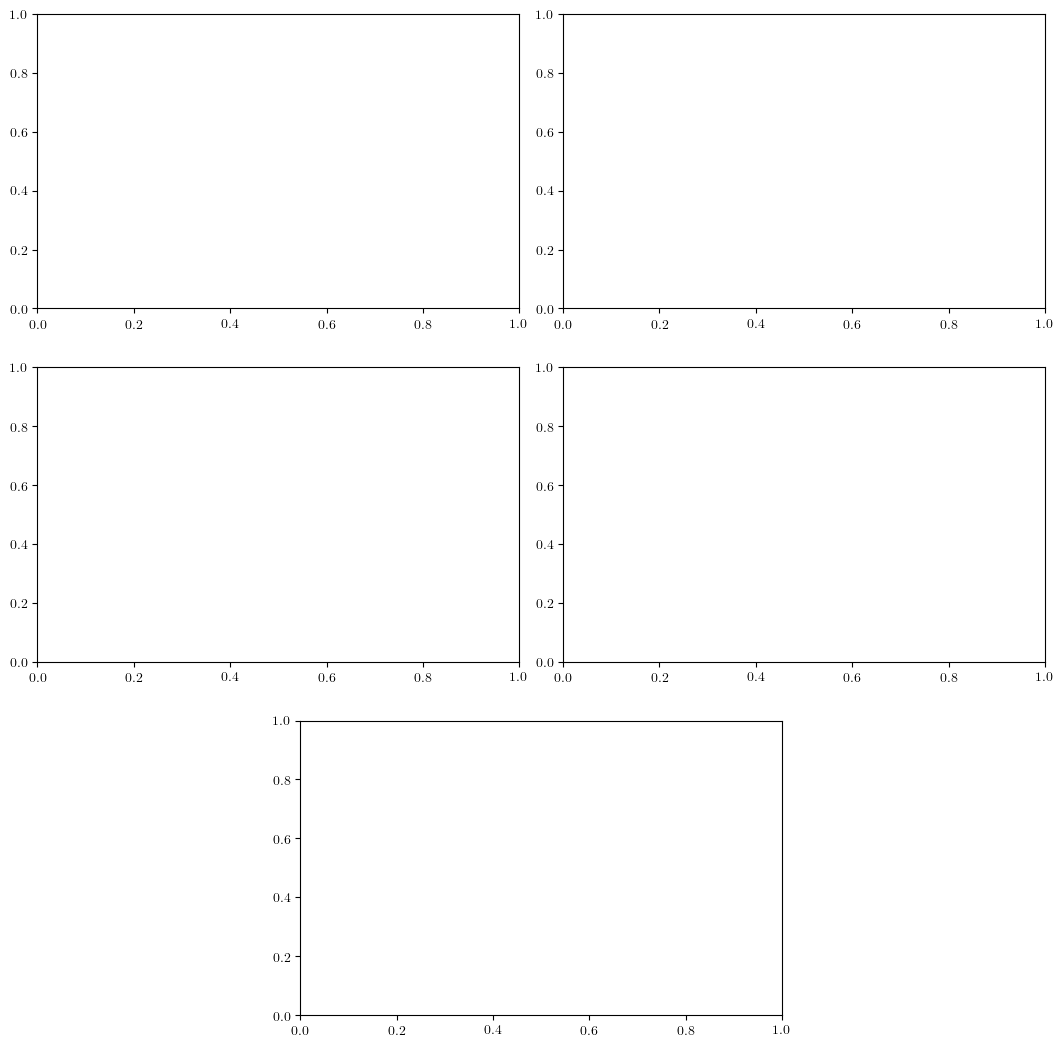

In [23]:
fig, ax = subplots_centered(3, 2, figsize = (13, 13), sharex = True, sharey = True, nfigs = 5)
hour_fod = [47,10,35,22,11]
FOD_df = pd.DataFrame()
for fod in range(1,6) :
    df = pd.DataFrame()
    for j, depid in enumerate(['ml18_294b','ml19_292b','ml19_293a','ml19_294a','ml20_296b']) :
        _df = get_corr_df(depids, depid, path, data = 'downwards_mean_5000', i = hour_fod[fod-1])
        df = pd.concat((df, _df[['FOD', 'mld_variation', 'LSTM', 'max_depth', 'meop_mld']]))
    df.reset_index(inplace = True), 
    df[df.LSTM < 5] = np.nan
    df = df[df.FOD == fod]
    FOD_df = pd.concat((FOD_df, df))
    sns.kdeplot(df, x = 'LSTM', y='mld_variation', ax = ax[fod-1])
    sns.regplot(df, x = 'LSTM', y='mld_variation', scatter = False, lowess = True, ax = ax[fod-1])
    #sns.regplot(df, x = 'LSTM', y='mld_variation', scatter = False, order = 2, ax = ax[fod-1])
    ax[fod-1].grid()
    ax[fod-1].set_xlabel('')
    ax[fod-1].set_ylabel('')
    ax[fod-1].set_ylim(-100, 200)
    ax[fod-1].set_title(f"FOD {fod}")
fig.text(0.56, 0.04, 'Wind speed (m/s)', ha='center', va='center', fontsize=14)
fig.text(0.04, 0.55, 'MLD variation (m)', ha='center', va='center', rotation='vertical', fontsize=14)
fig.tight_layout(rect=[0.05, 0.05, 1, 1])

In [ ]:
fig.savefig('C:/Users/grosm/Desktop/thèse/Figures/wind_impact_on_mld.pdf')

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10, 10))
df = pd.DataFrame()
for j, depid in enumerate(depids_with_mld) :
    _df = get_corr_df(depids, depid, path, data = 'downwards_mean_5000', i = 15)
    df = pd.concat((df, _df[['mld_variation', 'lstm_15h', 'max_depth', 'meop_mld']]))
df = df.reset_index()
ax.set_title('MLD variation after 15 hours and initial MLD')
ax.scatter(df.meop_mld, df.mld_variation,
                  color="orange", alpha=0.1)
ax.plot(np.linspace(0, 400, 100), 0.97*np.linspace(0, 400, 100) - 10.67, c = 'red')
ax.set_xlabel('MLD (m)')
ax.set_ylabel('MLD variation (m)')

In [ ]:
fig.savefig('C:/Users/grosm/Desktop/thèse/Figures/mld_variation.pdf')

### Wind gust duration

In [76]:
from scipy.signal import find_peaks, medfilt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Gaussian

In [12]:
def get_wind_gust(df, data = "lstm", time_diff = 15) :
    peaks, _ = find_peaks(df[data], prominence=1)
    timeframe = df.begin_time.to_numpy()
    begin_gust, end_gust = timeframe[_['left_bases']], timeframe[_['right_bases']]
    gust_pos = np.searchsorted(begin_gust, timeframe - time_diff*3600) - 1
    gust_val = [timeframe[i] - time_diff*3600 < end_gust[gust_pos[i]] for i in range(len(gust_pos))]
    gust_val = gust_val & (gust_pos >= 0)
    return df[data].to_numpy()[peaks[gust_pos[gust_val]]], (end_gust-begin_gust)[gust_pos[gust_val]], df.meop_mld.to_numpy()[gust_val], df.meop_mld.to_numpy()[gust_pos[gust_val]]

In [77]:
intercept, peaks_coef, duration_coef, p_values, peaks_pval, duration_pval, r_squared, adj_r_squared = [],[],[],[],[],[],[],[]
intercept_se, peaks_se, duration_se = [], [], []
r_squared_peaks, r_squared_duration = [], []

for j in range(1,48) :
    df = pd.DataFrame()
    for i, depid in enumerate(depids_with_mld) :
        _df = pd.read_csv(os.path.join(path, depid, f'{depid}_dive.csv'))
        peaks, duration, mld, previous_mld = get_wind_gust(_df, time_diff = j)
        df = pd.concat((df, pd.DataFrame({'peaks':peaks, 'duration':duration, 'mld':mld, 'previous_mld':previous_mld})))
    df.reset_index(inplace = True, drop = True)
    df['mld_diff'] = df['mld'] - df['previous_mld']
    df = df.dropna(subset=['peaks', 'duration', 'mld_diff'])
    
    X = df[['peaks', 'duration']] 
    X = sm.add_constant(X) 
    y = df['mld_diff'] 
    
    model = sm.OLS(y, X)
    #model = sm.GLMGam(y, X, family = Gaussian(), smoother = BSpline(df[['peaks', 'duration']] , df=6))
    results = model.fit()
    
    intercept_se.append(results.bse['const'])
    peaks_se.append(results.bse['peaks'])
    duration_se.append(results.bse['duration'])
    intercept.append(results.params['const'])
    peaks_coef.append(results.params['peaks'])
    duration_coef.append(results.params['duration'])
    p_values.append(results.pvalues.tolist())
    peaks_pval.append(results.pvalues['peaks']) 
    duration_pval.append(results.pvalues['duration'])
    r_squared.append(results.rsquared)
    adj_r_squared.append(results.rsquared_adj)
    
    X = df['peaks'] 
    X = sm.add_constant(X) 
    y = df['mld_diff'] 
    model = sm.OLS(y, X)
    results = model.fit()
    r_squared_peaks.append(results.rsquared)
    X = df['duration'] 
    X = sm.add_constant(X) 
    y = df['mld_diff'] 
    model = sm.OLS(y, X)
    results = model.fit()
    r_squared_duration.append(results.rsquared)


/tmp/ipykernel_12572/2497698469.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


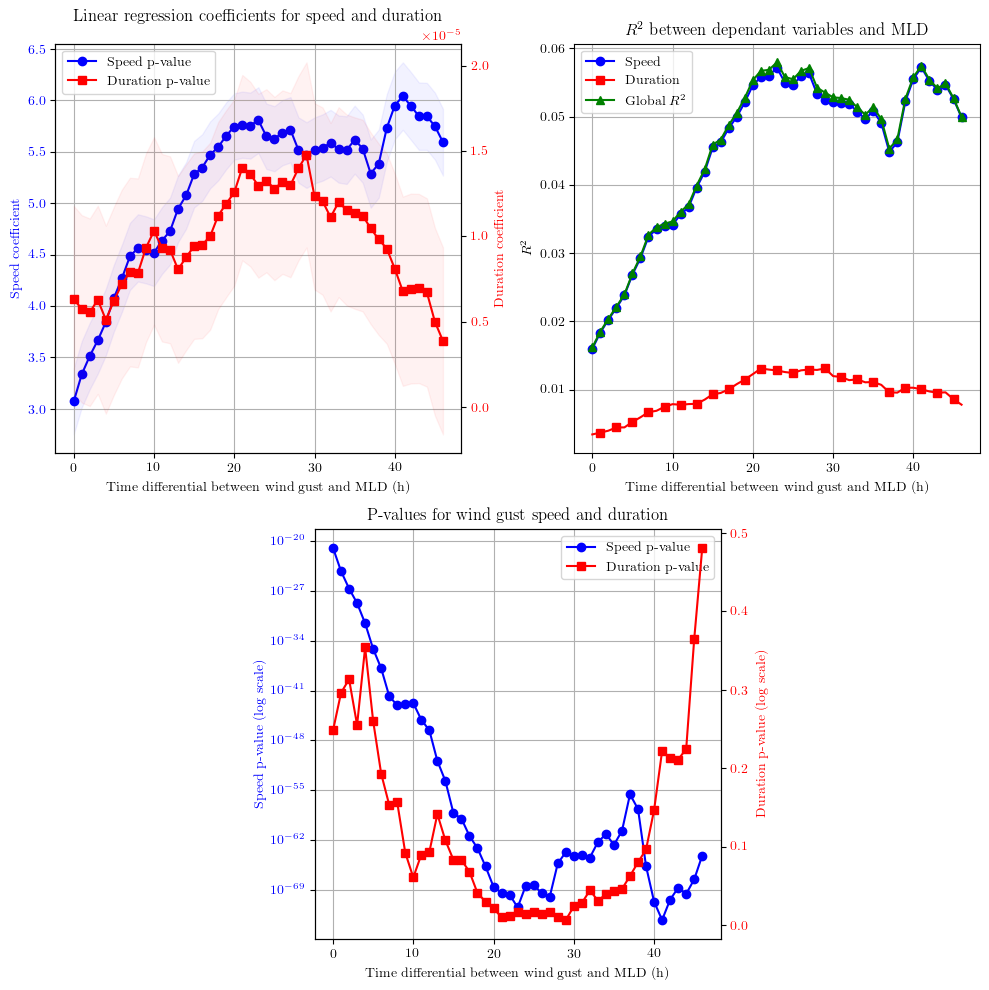

In [78]:
fig, ax = subplots_centered(2, 2, figsize=(10, 10), nfigs = 3)

peaks_coef = np.array(peaks_coef)
peaks_se = np.array(peaks_se)
duration_coef = np.array(duration_coef)
duration_se = np.array(duration_se)

ax0 = ax[0]
ax1 = ax0.twinx()
line1 = ax0.plot(peaks_coef, color='blue', label='Speed p-value', marker='o')
ax0.set_ylabel('Speed coefficient', color='blue')
ax0.tick_params(axis='y', labelcolor='blue')
line2 = ax1.plot(duration_coef, color='red', label='Duration p-value', marker='s')
ax1.set_ylabel('Duration coefficient', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax0.fill_between(range(len(peaks_coef)), peaks_coef - peaks_se, peaks_coef + peaks_se, color='blue', alpha=0.05)
ax1.fill_between(range(len(duration_coef)), duration_coef - duration_se, duration_coef + duration_se, color='red', alpha=0.05)
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax0.legend(lines, labels, loc='upper left')
ax0.grid()
ax[0].set_xlabel('Time differential between wind gust and MLD (h)')
ax[0].set_title('Linear regression coefficients for speed and duration')


ax[1].plot(r_squared_peaks, color='blue', label='Speed', marker='o')
ax[1].plot(r_squared_duration, color='red', label='Duration', marker='s', markevery=(1,2))
ax[1].plot(r_squared, color='green', label=r'Global $R^2$', marker='^')

ax[1].set_ylabel(r'$R^2$')
ax[1].set_xlabel('Time differential between wind gust and MLD (h)')
ax[1].legend()
ax[1].set_title(r'$R^2$ between dependant variables and MLD')
ax[1].grid()

ax0 = ax[2]
ax1 = ax0.twinx()
line1 = ax0.plot(peaks_pval, color='blue', label='Speed p-value', marker='o')
ax0.set_yscale('log')
ax0.set_ylabel('Speed p-value (log scale)', color='blue')
ax0.tick_params(axis='y', labelcolor='blue')
line2 = ax1.plot(duration_pval, color='red', label='Duration p-value', marker='s')
#ax1.set_yscale('log')
ax1.set_ylabel('Duration p-value (log scale)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax0.legend(lines, labels, loc='upper right')
ax[2].set_xlabel('Time differential between wind gust and MLD (h)')
ax[2].set_title('P-values for wind gust speed and duration')
ax[2].grid()

fig.tight_layout()
fig.show()

In [79]:
fig.savefig('/home6/grosmaan/Documents/Figures/wind_gust_dependant_variable.pdf')

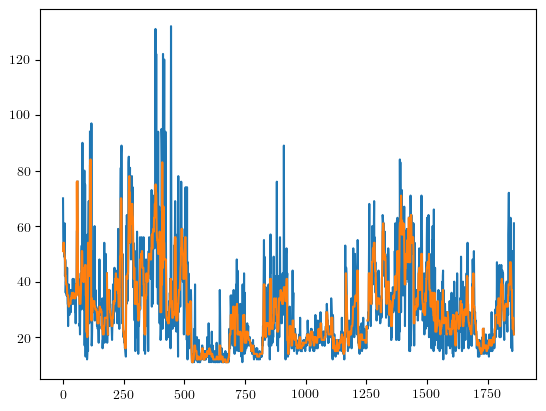

In [66]:
plt.plot(_df.meop_mld)
plt.plot(medfilt(_df.meop_mld, 7))